In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import pandas as pd
import numpy as np
import os 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn import svm



In [17]:
train_file = pd.read_csv('iot-datasets/train.csv')
test_file = pd.read_csv('iot-datasets/test.csv')
severity_type = pd.read_csv('iot-datasets/severity_type.csv')
event_type = pd.read_csv('iot-datasets/event_type.csv')
log_feature = pd.read_csv('iot-datasets/log_feature.csv')
resource_type = pd.read_csv('iot-datasets/resource_type.csv')

In [18]:
df = train_file.merge(severity_type, how = 'left', left_on='id', right_on='id')
df = df.merge(resource_type, how = 'left', left_on='id', right_on='id')
df = df.merge(log_feature, how = 'left', left_on='id', right_on='id')
df = df.merge(event_type, how = 'left', left_on='id', right_on='id')

In [19]:
df.head()

,id,location,fault_severity,severity_type,resource_type,log_feature,volume,event_type
0,14121,location 118,1,severity_type 2,resource_type 2,feature 312,19,event_type 34
1,14121,location 118,1,severity_type 2,resource_type 2,feature 312,19,event_type 35
2,14121,location 118,1,severity_type 2,resource_type 2,feature 232,19,event_type 34
3,14121,location 118,1,severity_type 2,resource_type 2,feature 232,19,event_type 35
4,9320,location 91,0,severity_type 2,resource_type 2,feature 315,200,event_type 34


In [20]:
df.isnull().sum()

id                0
location          0
fault_severity    0
severity_type     0
resource_type     0
log_feature       0
volume            0
event_type        0
dtype: int64

In [21]:
df.drop_duplicates(subset='id',keep='first',inplace=True)

In [22]:
df.head()

,id,location,fault_severity,severity_type,resource_type,log_feature,volume,event_type
0,14121,location 118,1,severity_type 2,resource_type 2,feature 312,19,event_type 34
4,9320,location 91,0,severity_type 2,resource_type 2,feature 315,200,event_type 34
8,14394,location 152,1,severity_type 2,resource_type 2,feature 221,1,event_type 35
12,8218,location 931,1,severity_type 1,resource_type 8,feature 80,9,event_type 15
18,14804,location 120,0,severity_type 1,resource_type 2,feature 134,1,event_type 34


In [23]:
df.shape

(7381, 8)

## Convert features into numbers

In [24]:
df.dtypes

id                 int64
location          object
fault_severity     int64
severity_type     object
resource_type     object
log_feature       object
volume             int64
event_type        object
dtype: object

In [25]:
def extract(column_names):
    for name in column_names:
        df[name] = df[name].str.extract(r'(\d+)').astype(int)
    return df
column_names = list(df.select_dtypes(include=['object']).columns)
df = extract(column_names)

In [26]:
df.dtypes

id                int64
location          int64
fault_severity    int64
severity_type     int64
resource_type     int64
log_feature       int64
volume            int64
event_type        int64
dtype: object

## Split dataset

In [27]:
y = df['fault_severity']
X = df.drop(['fault_severity','id'], axis=1)
print("Number of examples: " + str(X.shape[0]))
print("\nNumber of Features:" + str(X.shape[1]))
print(str(list(X.columns)))

Number of examples: 7381

Number of Features:6
['location', 'severity_type', 'resource_type', 'log_feature', 'volume', 'event_type']


In [28]:
X_train,X_test, y_train,y_test =  train_test_split(X,y, test_size=0.33,random_state=1234)

## Logistic regression

In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4945, 6)
(4945,)
(2436, 6)
(2436,)


In [30]:
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)

/Users/ghomefolder/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
from sklearn.metrics import accuracy_score, classification_report
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print('Accuracy score of model: ' + str(lr_accuracy))


Accuracy score of model: 0.6395730706075534


## KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X_train, y_train) 

knn_y_pred = knn_model.predict(X_test) 

/Users/ghomefolder/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [33]:
knn_accuracy = accuracy_score(y_test, knn_y_pred)
print('Accuracy score of model: ' + str(knn_accuracy))

Accuracy score of model: 0.6342364532019704


## Decision Tree

In [43]:
param_grid = {'max_depth':[4,8],'min_samples_leaf':[25,50]}
print('Running grid search')
dt_regressor = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt_regressor,param_grid,cv=3, scoring='neg_root_mean_squared_error')
dt_grid_search = dt_grid.fit(X_train,y_train)
print('finished grid search')


#get the best parameters for decision tree
dt_best_params= dt_grid_search.best_params_
print(f"best parameters for decision tree model: {dt_best_params}")
dt_model = DecisionTreeClassifier(max_depth=dt_best_params['max_depth'], min_samples_leaf=dt_best_params['min_samples_leaf'])
dt_model.fit(X_train, y_train)
y_dt_pred =dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_dt_pred)
print("Accuracy:", dt_accuracy)


Running grid search
finished grid search
best parameters for decision tree model: {'max_depth': 8, 'min_samples_leaf': 50}
Accuracy: 0.6687192118226601


## Random Forest

In [44]:
param_grid = {'max_depth':[4,8,10,20,32],'n_estimators':[25,50,100,200,300]}
print('Running grid search')
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(rf_model,param_grid,cv=3, scoring='neg_root_mean_squared_error')
rf_grid_search = rf_grid.fit(X_train,y_train)
print('finished grid search')

rf_best_params= rf_grid_search.best_params_
print(f"best parameters for rf model: {rf_best_params}")
rf_model = RandomForestClassifier(max_depth=rf_best_params['max_depth'],n_estimators = rf_best_params['n_estimators'])
rf_model.fit(X_train, y_train)
y_rf_pred=rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_rf_pred)
print("Accuracy:", rf_accuracy)


Running grid search
finished grid search
best parameters for rf model: {'max_depth': 10, 'n_estimators': 200}
Accuracy: 0.6859605911330049


## GBDT

In [37]:

param_grid = {'max_depth':[4,8,10],'n_estimators':[25,50,100,200,300]}
print('Running grid search')
gbdt_model = GradientBoostingClassifier()
GBDT_grid = GridSearchCV(gbdt_model,param_grid,cv=3, scoring='neg_root_mean_squared_error')
GBDT_grid_search = GBDT_grid.fit(X_train,y_train)
print('finished grid search')


GBDT_best_params= GBDT_grid_search.best_params_
print(f"best parameters for GBDT model: {GBDT_best_params}")

gbdt_model = GradientBoostingClassifier(max_depth=GBDT_best_params['max_depth'], n_estimators=GBDT_best_params['n_estimators'])
gbdt_model.fit(X_train,y_train)
y_gbdt_pred =  gbdt_model.predict(X_test)


Running grid search


finished grid search
best parameters for GBDT model: {'max_depth': 4, 'n_estimators': 100}


In [38]:
gbdt_accuracy = accuracy_score(y_test, y_gbdt_pred)
print("Accuracy:", gbdt_accuracy)

Accuracy: 0.7048440065681445


## Naive Bayes

In [39]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_y_pred = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_y_pred)
print("Accuracy:", nb_accuracy)

Accuracy: 0.5172413793103449


## SVM

In [55]:
svm_model_linear = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
svm_y_pred = svm_model_linear.predict(X_test) 
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print("Accuracy:", svm_accuracy)


Accuracy: 0.6416256157635468


In [52]:
feature_imp = gbdt_model.feature_importances_
df_features = pd.DataFrame({'name':X_train.columns.values, 'imp':feature_imp})
df_sorted =df_features.sort_values(by=['imp'],  ascending=False)
top_five = df_sorted.iloc[:6]['name'].tolist()
print('Top five features: {0}'.format(top_five))

Top five features: ['location', 'log_feature', 'volume', 'resource_type', 'event_type', 'severity_type']


Text(0, 0.5, 'Normalized importance')

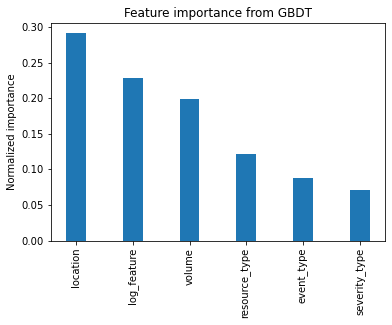

In [54]:
fig, ax = plt.subplots()
ax.bar(np.arange(6), sorted(rf_model.feature_importances_, reverse=True)[:6], width = 0.35)
ax.set_xticks(np.arange(6))
ax.set_xticklabels(top_five, rotation = 90)
plt.title('Feature importance from GBDT')
ax.set_ylabel('Normalized importance')

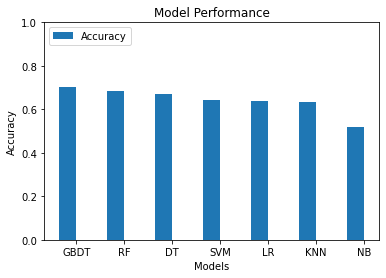

In [62]:
accuracy_results = [lr_accuracy, knn_accuracy, dt_accuracy, rf_accuracy, gbdt_accuracy, nb_accuracy, svm_accuracy]
labels = ['LR', 'KNN', 'DT', 'RF', 'GBDT', 'NB', 'SVM']
label_accuracy_pairs = list(zip(labels, accuracy_results))
sorted_label_accuracy_pairs = sorted(label_accuracy_pairs, key=lambda x: x[1], reverse=True)
accuracy_results = [pair[1] for pair in sorted_label_accuracy_pairs]

labels = [pair[0] for pair in sorted_label_accuracy_pairs]

rg= np.arange(7)
width = 0.35
plt.bar(rg, accuracy_results, width, label="Accuracy")
plt.xticks(rg + width/2, labels)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim([0,1])

plt.title('Model Performance')
plt.legend(loc='upper left', ncol=2)
plt.show()
